In [28]:
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip"
urllib.request.urlretrieve(url, "./fr.openfoodfacts.org.products.csv.zip")

('./fr.openfoodfacts.org.products.csv.zip',
 <http.client.HTTPMessage at 0x217f52a8a10>)

In [29]:
with zipfile.ZipFile("./fr.openfoodfacts.org.products.csv.zip", 'r') as zipRef:
    with zipRef.open('fr.openfoodfacts.org.products.csv') as file:
        data = pd.read_csv(file, sep="\t", low_memory=False)

In [30]:
varList = data.columns.tolist()
sizeData = data.shape[0]
print(varList)

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

In [31]:
startNut = varList.index("energy_100g")
print(startNut)

63


In [32]:
size = data[data.duplicated()].shape[0]
if size == 0:
    print("No exact duplicated")
else:
    print(f"exact duplicated :{size}")
subset = ['code']
size = sizeSubset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"exact duplicated with subset {subset} :{size}")
subset = ['product_name', 'creator', 'quantity']
size = sizeSubset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"Possible duplicated with subset {subset} :{size}")
subset = ['product_name', 'brands', 'quantity', 'categories', 'countries']
size = sizeSubset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"Possible duplicated with subset {subset} :{size}")


No exact duplicated
No possible duplicated with subset : ['code']
Possible duplicated with subset ['product_name', 'creator', 'quantity'] :1939
Possible duplicated with subset ['product_name', 'brands', 'quantity', 'categories', 'countries'] :138


In [33]:
missingRate = data.iloc[:, :startNut].isnull().sum()/sizeData
print(missingRate.shape[0])
print(missingRate[missingRate >= 0.5])

63
generic_name                                 0.84
quantity                                     0.67
packaging                                    0.75
packaging_tags                               0.75
categories                                   0.74
categories_tags                              0.74
categories_fr                                0.74
origins                                      0.93
origins_tags                                 0.93
manufacturing_places                         0.89
manufacturing_places_tags                    0.89
labels                                       0.85
labels_tags                                  0.85
labels_fr                                    0.85
emb_codes                                    0.91
emb_codes_tags                               0.91
first_packaging_code_geo                     0.94
cities                                       1.00
cities_tags                                  0.94
purchase_places                              0.

In [34]:
missingRateNut = data.iloc[:, startNut:].isnull().sum()/sizeData
print(missingRateNut.shape[0])
print(missingRateNut[missingRateNut >= 0.5])

99
energy-from-fat_100g    1.00
butyric-acid_100g       1.00
caproic-acid_100g       1.00
caprylic-acid_100g      1.00
capric-acid_100g        1.00
                        ... 
cocoa_100g              1.00
chlorophyl_100g         1.00
carbon-footprint_100g   1.00
glycemic-index_100g     1.00
water-hardness_100g     1.00
Length: 88, dtype: float64


In [35]:
def prepareData(data, targetColumn, subsetDup):
    if targetColumn not in data.columns:
        raise ValueError(f"{targetColumn} is not in dataFrame.")

    dataCleaned = data.dropna(subset=[targetColumn])
    y = dataCleaned[targetColumn]
    X = dataCleaned.drop(columns=[targetColumn])

    columnsKeep = X.columns[X.isnull().mean() < 0.5]
    X = X[columnsKeep]
    
    subsetDup = [col for col in subsetDup if col in X.columns]
    
    if subsetDup:
        X = X.drop_duplicates(subset=subsetDup)
        y = y.loc[X.index]
    else:
        print("No target for subsetDup.")
    return X, y

In [36]:
try:
    subsetDup = ['product_name', 'brands', 'quantity', 'categories', 'countries']
    XClean, y = prepareData(data, 'nutrition_grade_fr', subsetDup)

    print("Nb raws after clean :", len(XClean))
    print("Nb features:", XClean.shape[1])
    columnsX = XClean.columns.tolist()
    print("\n10 first features:")
    print(columnsX[:10])
    startNut = columnsX.index("energy_100g")
    print("\nFeatures nutritional:")
    print(columnsX[startNut : ])
    print("\nDistribution of the target variable:")
    print(y.value_counts(normalize=True))
    
    print("\nDescriptive statistics for some numeric columns:")
    numericColumns = [
    'energy_100g',
    'fat_100g',
    'saturated-fat_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
    'nutrition-score-fr_100g', 
    'nutrition-score-uk_100g'
    ]
    print(f'Features needed in Nutriscoring : {numericColumns}')
    numericColumns = [col for col in numericColumns if col in XClean.columns]
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(XClean[numericColumns].describe())

except Exception as e:
    print(f"Error : {e}")

Nb raws after clean : 205268
Nb features: 41

10 first features:
['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'brands', 'brands_tags']

Features nutritional:
['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

Distribution of the target variable:
nutrition_grade_fr
d   0.28
c   0.21
e   0.19
a   0.16
b   0.15
Name: proportion, dtype: float64

Descriptive statistics for some numeric columns:
Features needed in Nutriscoring : ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
       energy_100g  fat_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
coun

In [37]:
def cleanOutliers(data, columns, lowerPercentile=0.01, upperPercentile=0.9999):
    dataClean = data.copy()
    for col in columns:
        if np.issubdtype(dataClean[col].dtype, np.number):
            lower = dataClean[col].quantile(lowerPercentile)
            upper = dataClean[col].quantile(upperPercentile)
            dataClean[col] = dataClean[col].clip(lower, upper)
        else:
            print(f"Column {col} not a number.")
    return dataClean

In [38]:
XClean = cleanOutliers(XClean, numericColumns)

In [39]:
def plotBoxplots(data, columns):
    plt.figure(figsize=(15, 5 * (len(columns) // 3 + 1)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.boxplot(x=data[col])
    plt.tight_layout()
    plt.show()

In [40]:
def plotHistograms(data, columns):
    plt.figure(figsize=(15, 5 * (len(columns) // 3 + 1)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.histplot(data[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

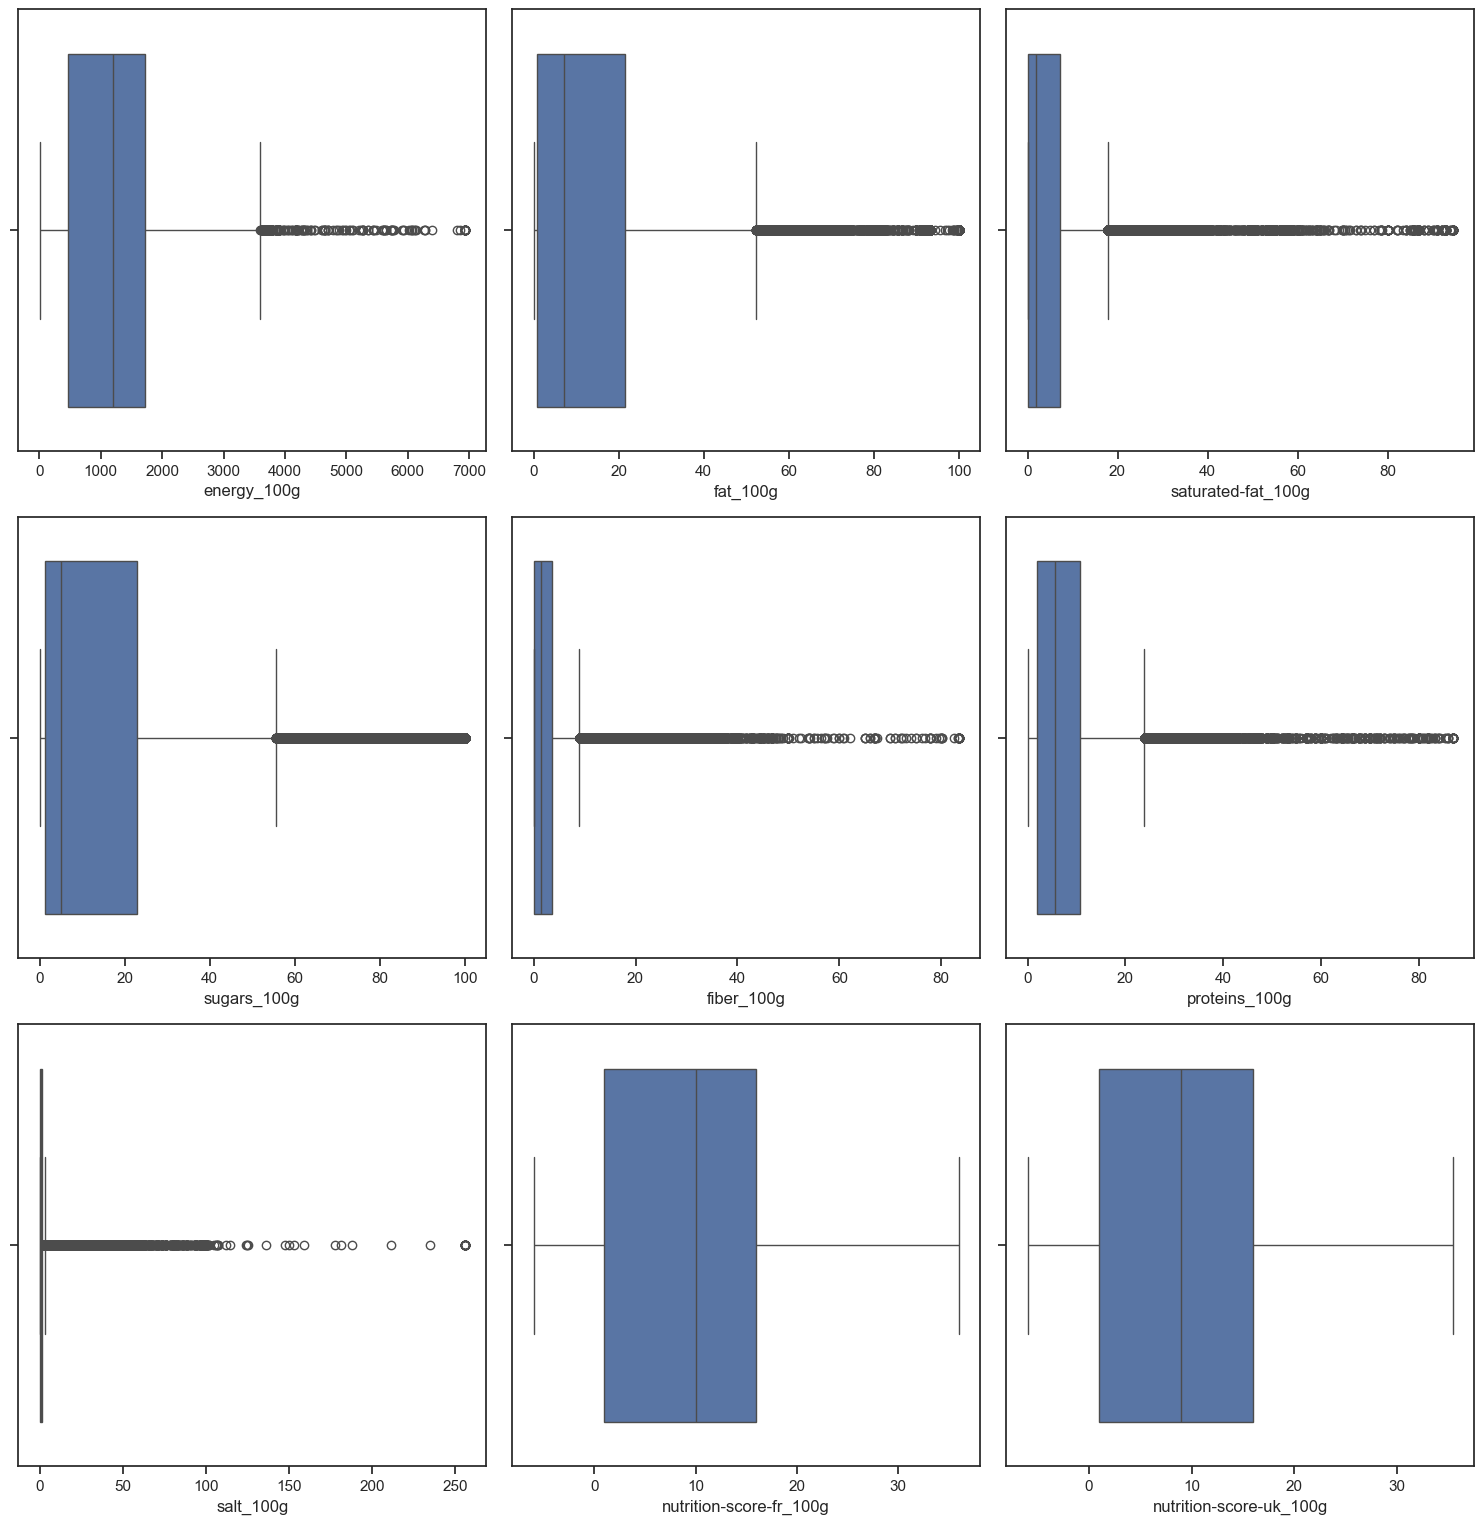

In [41]:
plotBoxplots(XClean, numericColumns)

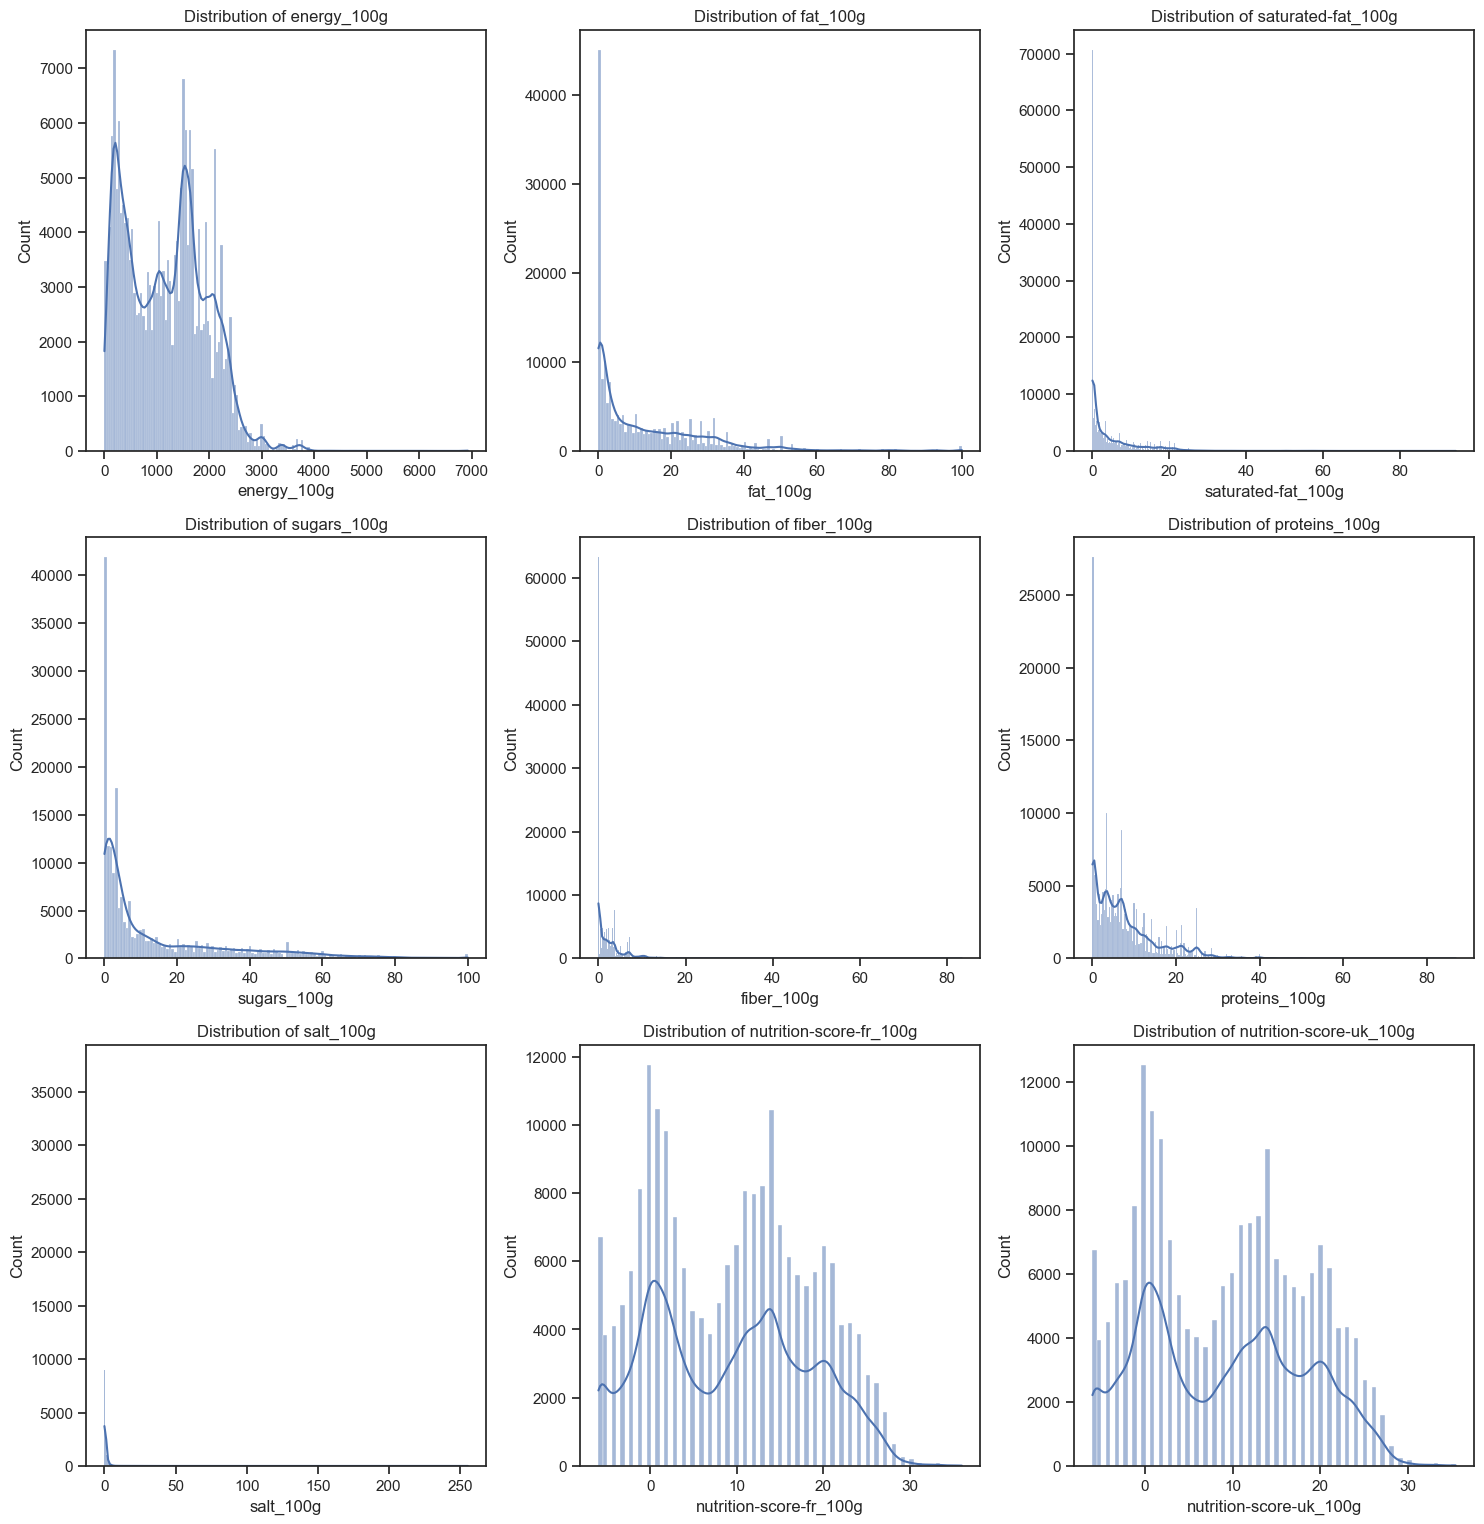

In [42]:
plotHistograms(XClean, numericColumns)

In [43]:
def treatOutliers(data, thresholds):
    dataClean = data.copy()
    for col, (minVal, maxVal) in thresholds.items():
        if col in data.columns:
            dataClean.loc[dataClean[col] < minVal, col] = minVal
            dataClean.loc[dataClean[col] > maxVal, col] = maxVal
    return dataClean

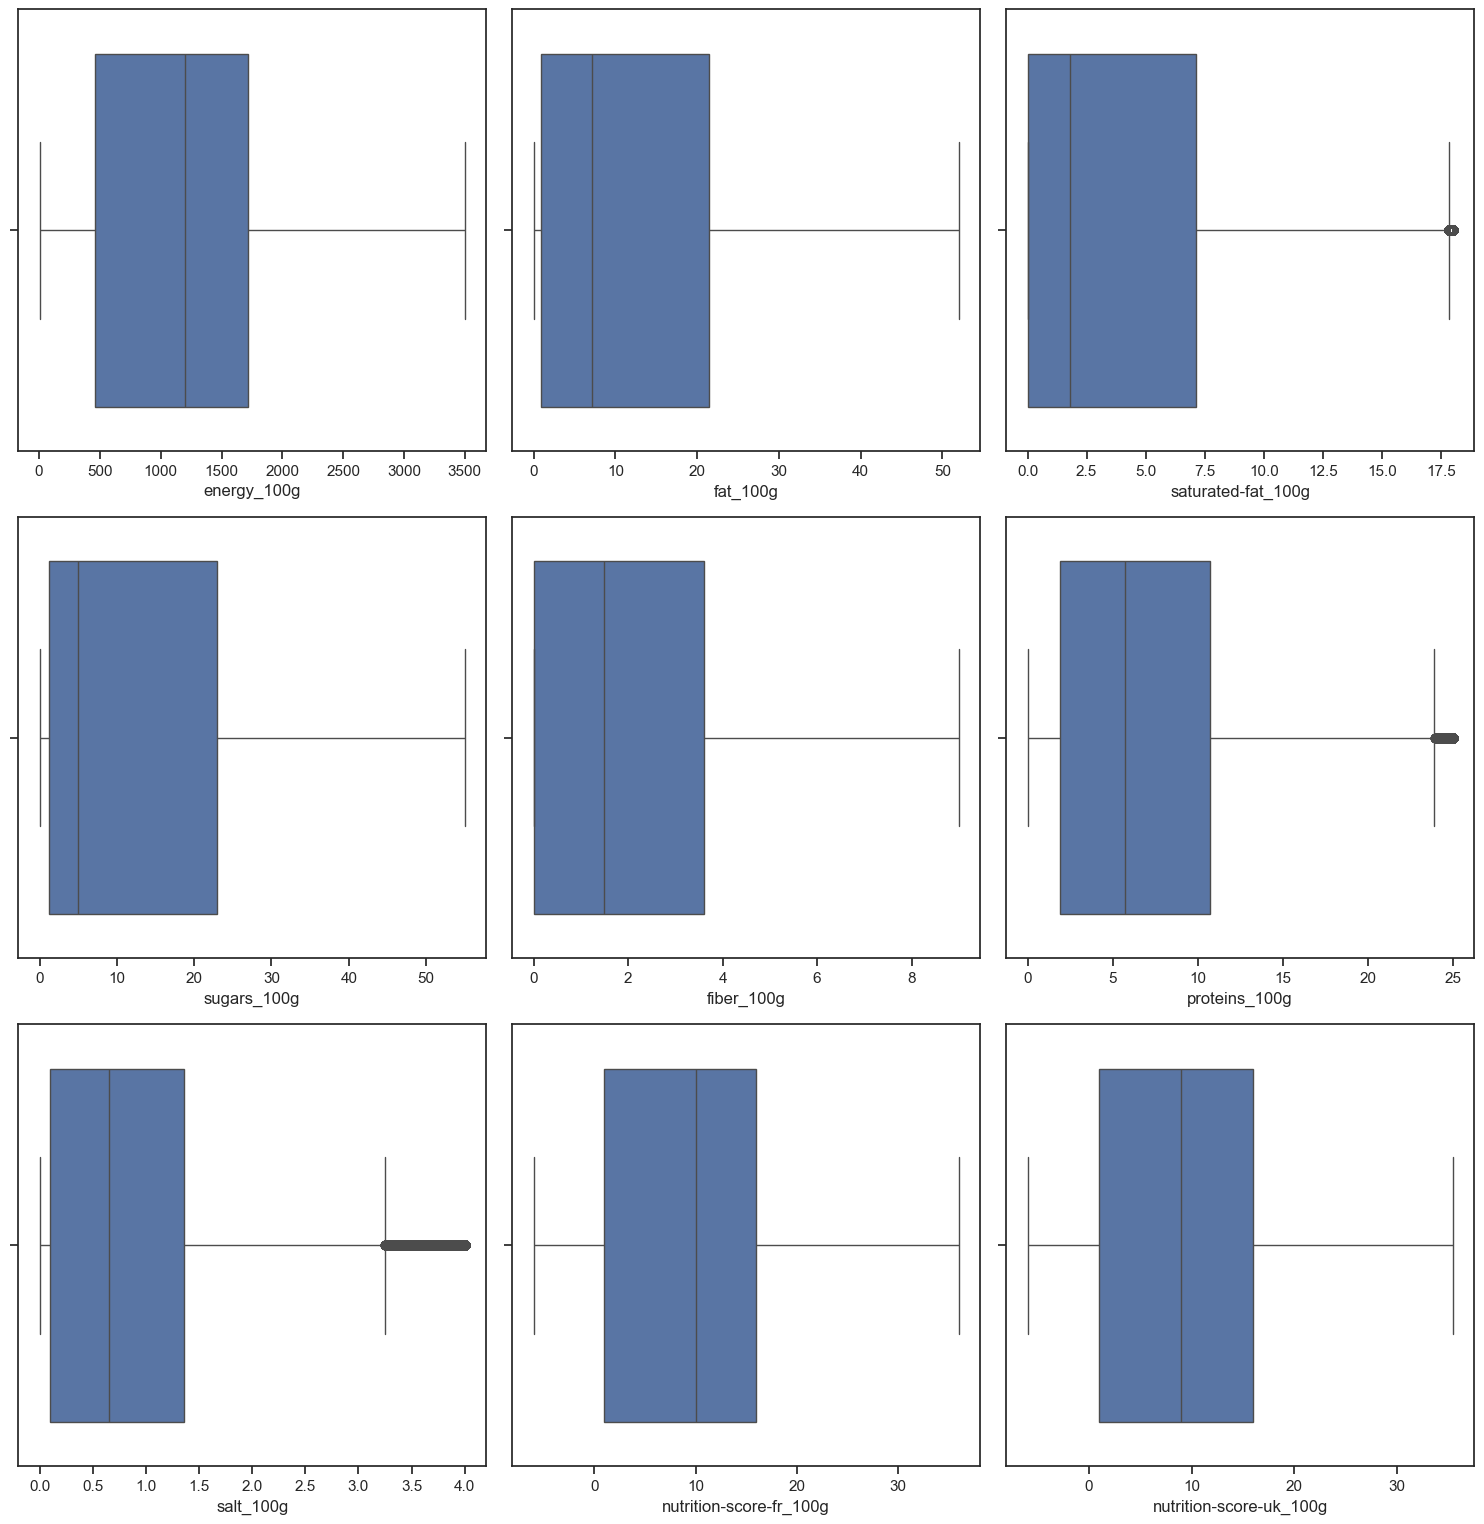

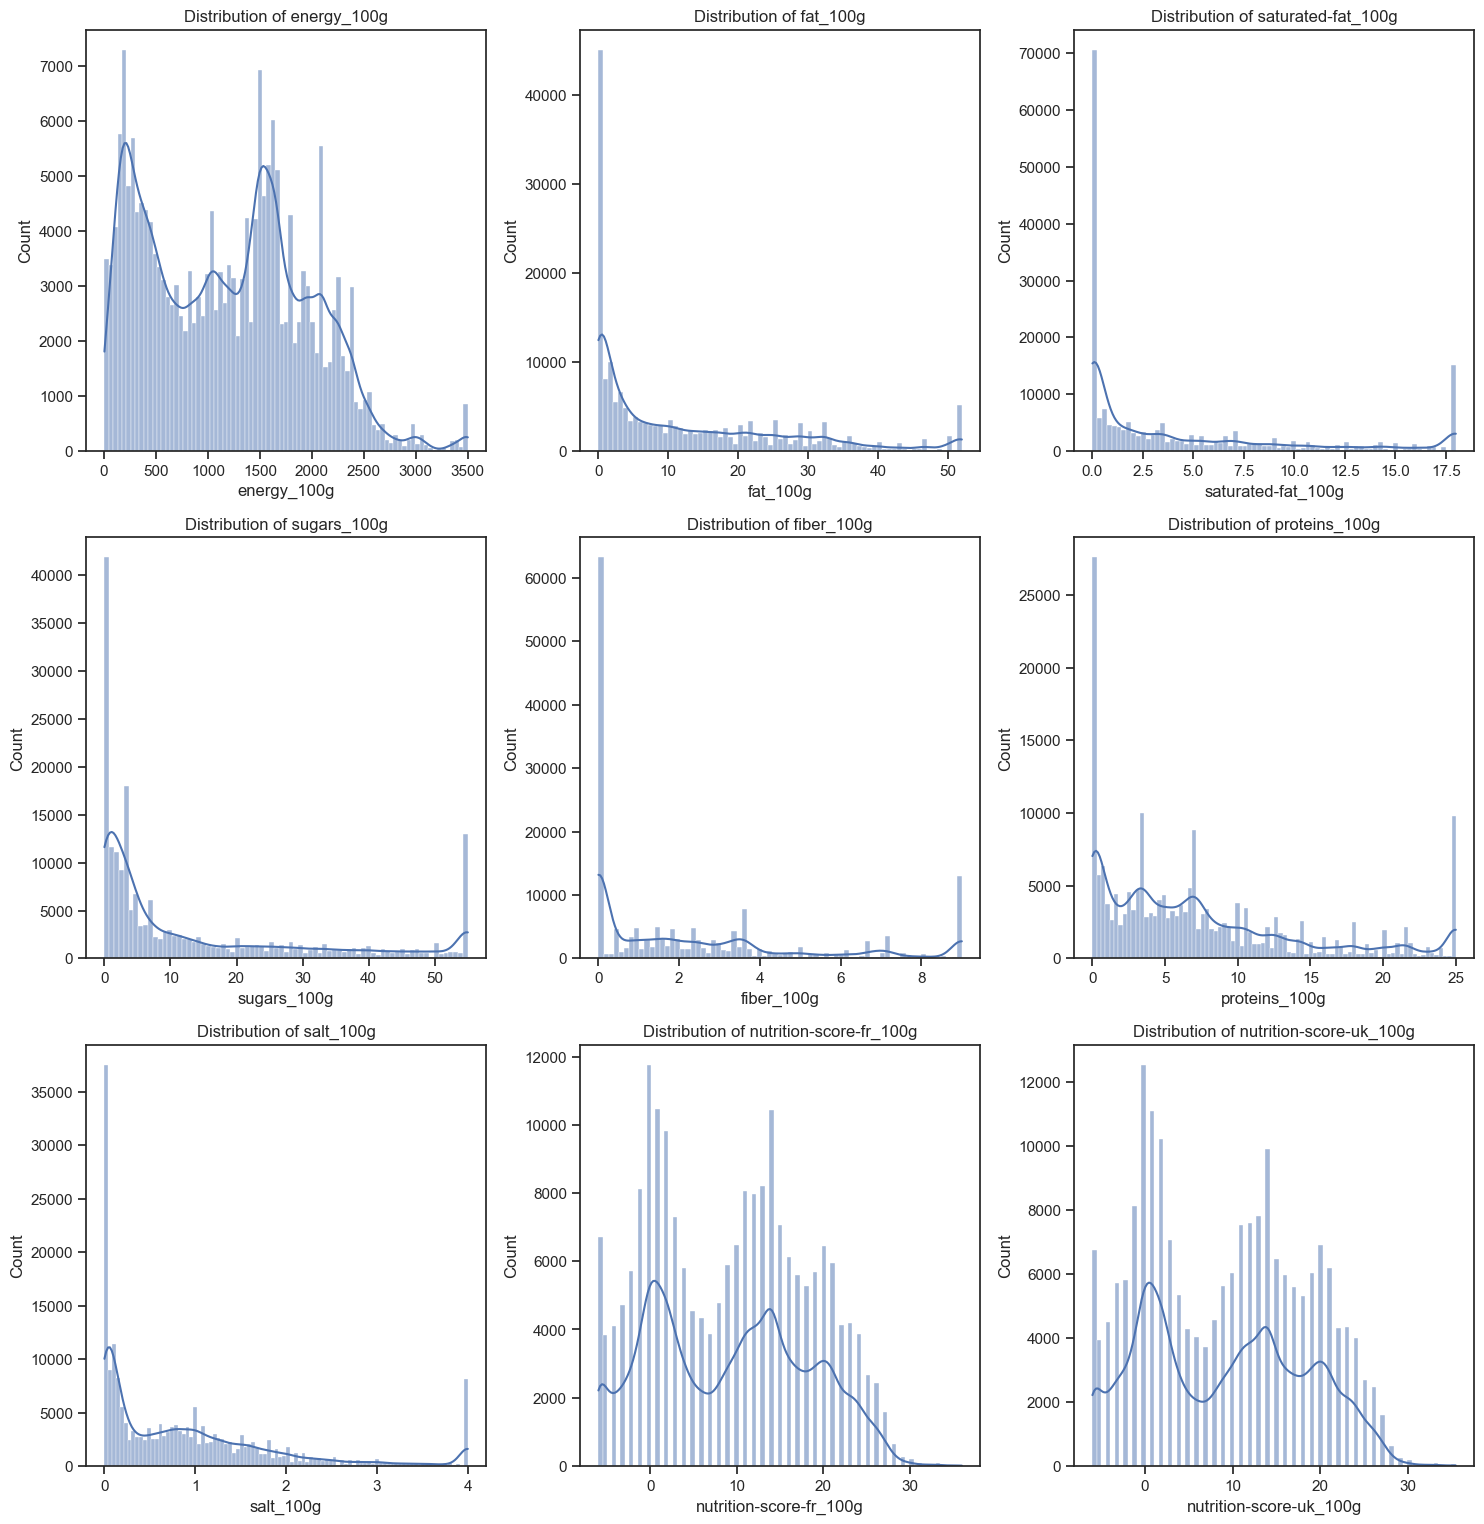

In [44]:
outlierThresholds = {
    'energy_100g': (0, 3500),
    'fat_100g': (0, 52),
    'saturated-fat_100g': (0, 18),
    'sugars_100g': (0, 55),
    'fiber_100g': (0, 9),
    'proteins_100g': (0, 25),
    'salt_100g': (0, 4),
    'sodium_100g': (0, 1.5)
}

XClean = treatOutliers(XClean, outlierThresholds)
plotBoxplots(XClean, numericColumns)
plotHistograms(XClean, numericColumns)

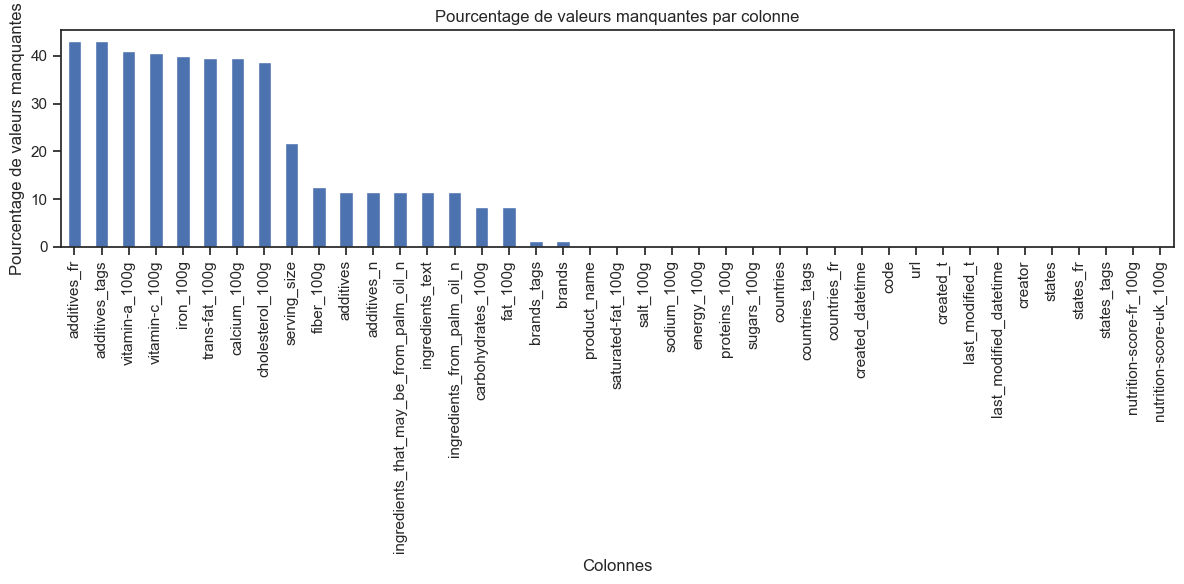

In [45]:
missing_percentages = (XClean.isnull().mean() * 100).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
missing_percentages.plot(kind='bar')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de valeurs manquantes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#print(missing_percentages)

In [46]:
def impute_missing_values(data):
    dataImputed = data.copy()
    
    numericColumns = data.select_dtypes(include=[np.number]).columns
    for col in numericColumns:
        dataImputed[col] = dataImputed[col].fillna(dataImputed[col].median())
    
    return dataImputed

In [47]:
XImputed = impute_missing_values(XClean)
missing_percentages = (XImputed.isnull().mean() * 100).sort_values(ascending=False)

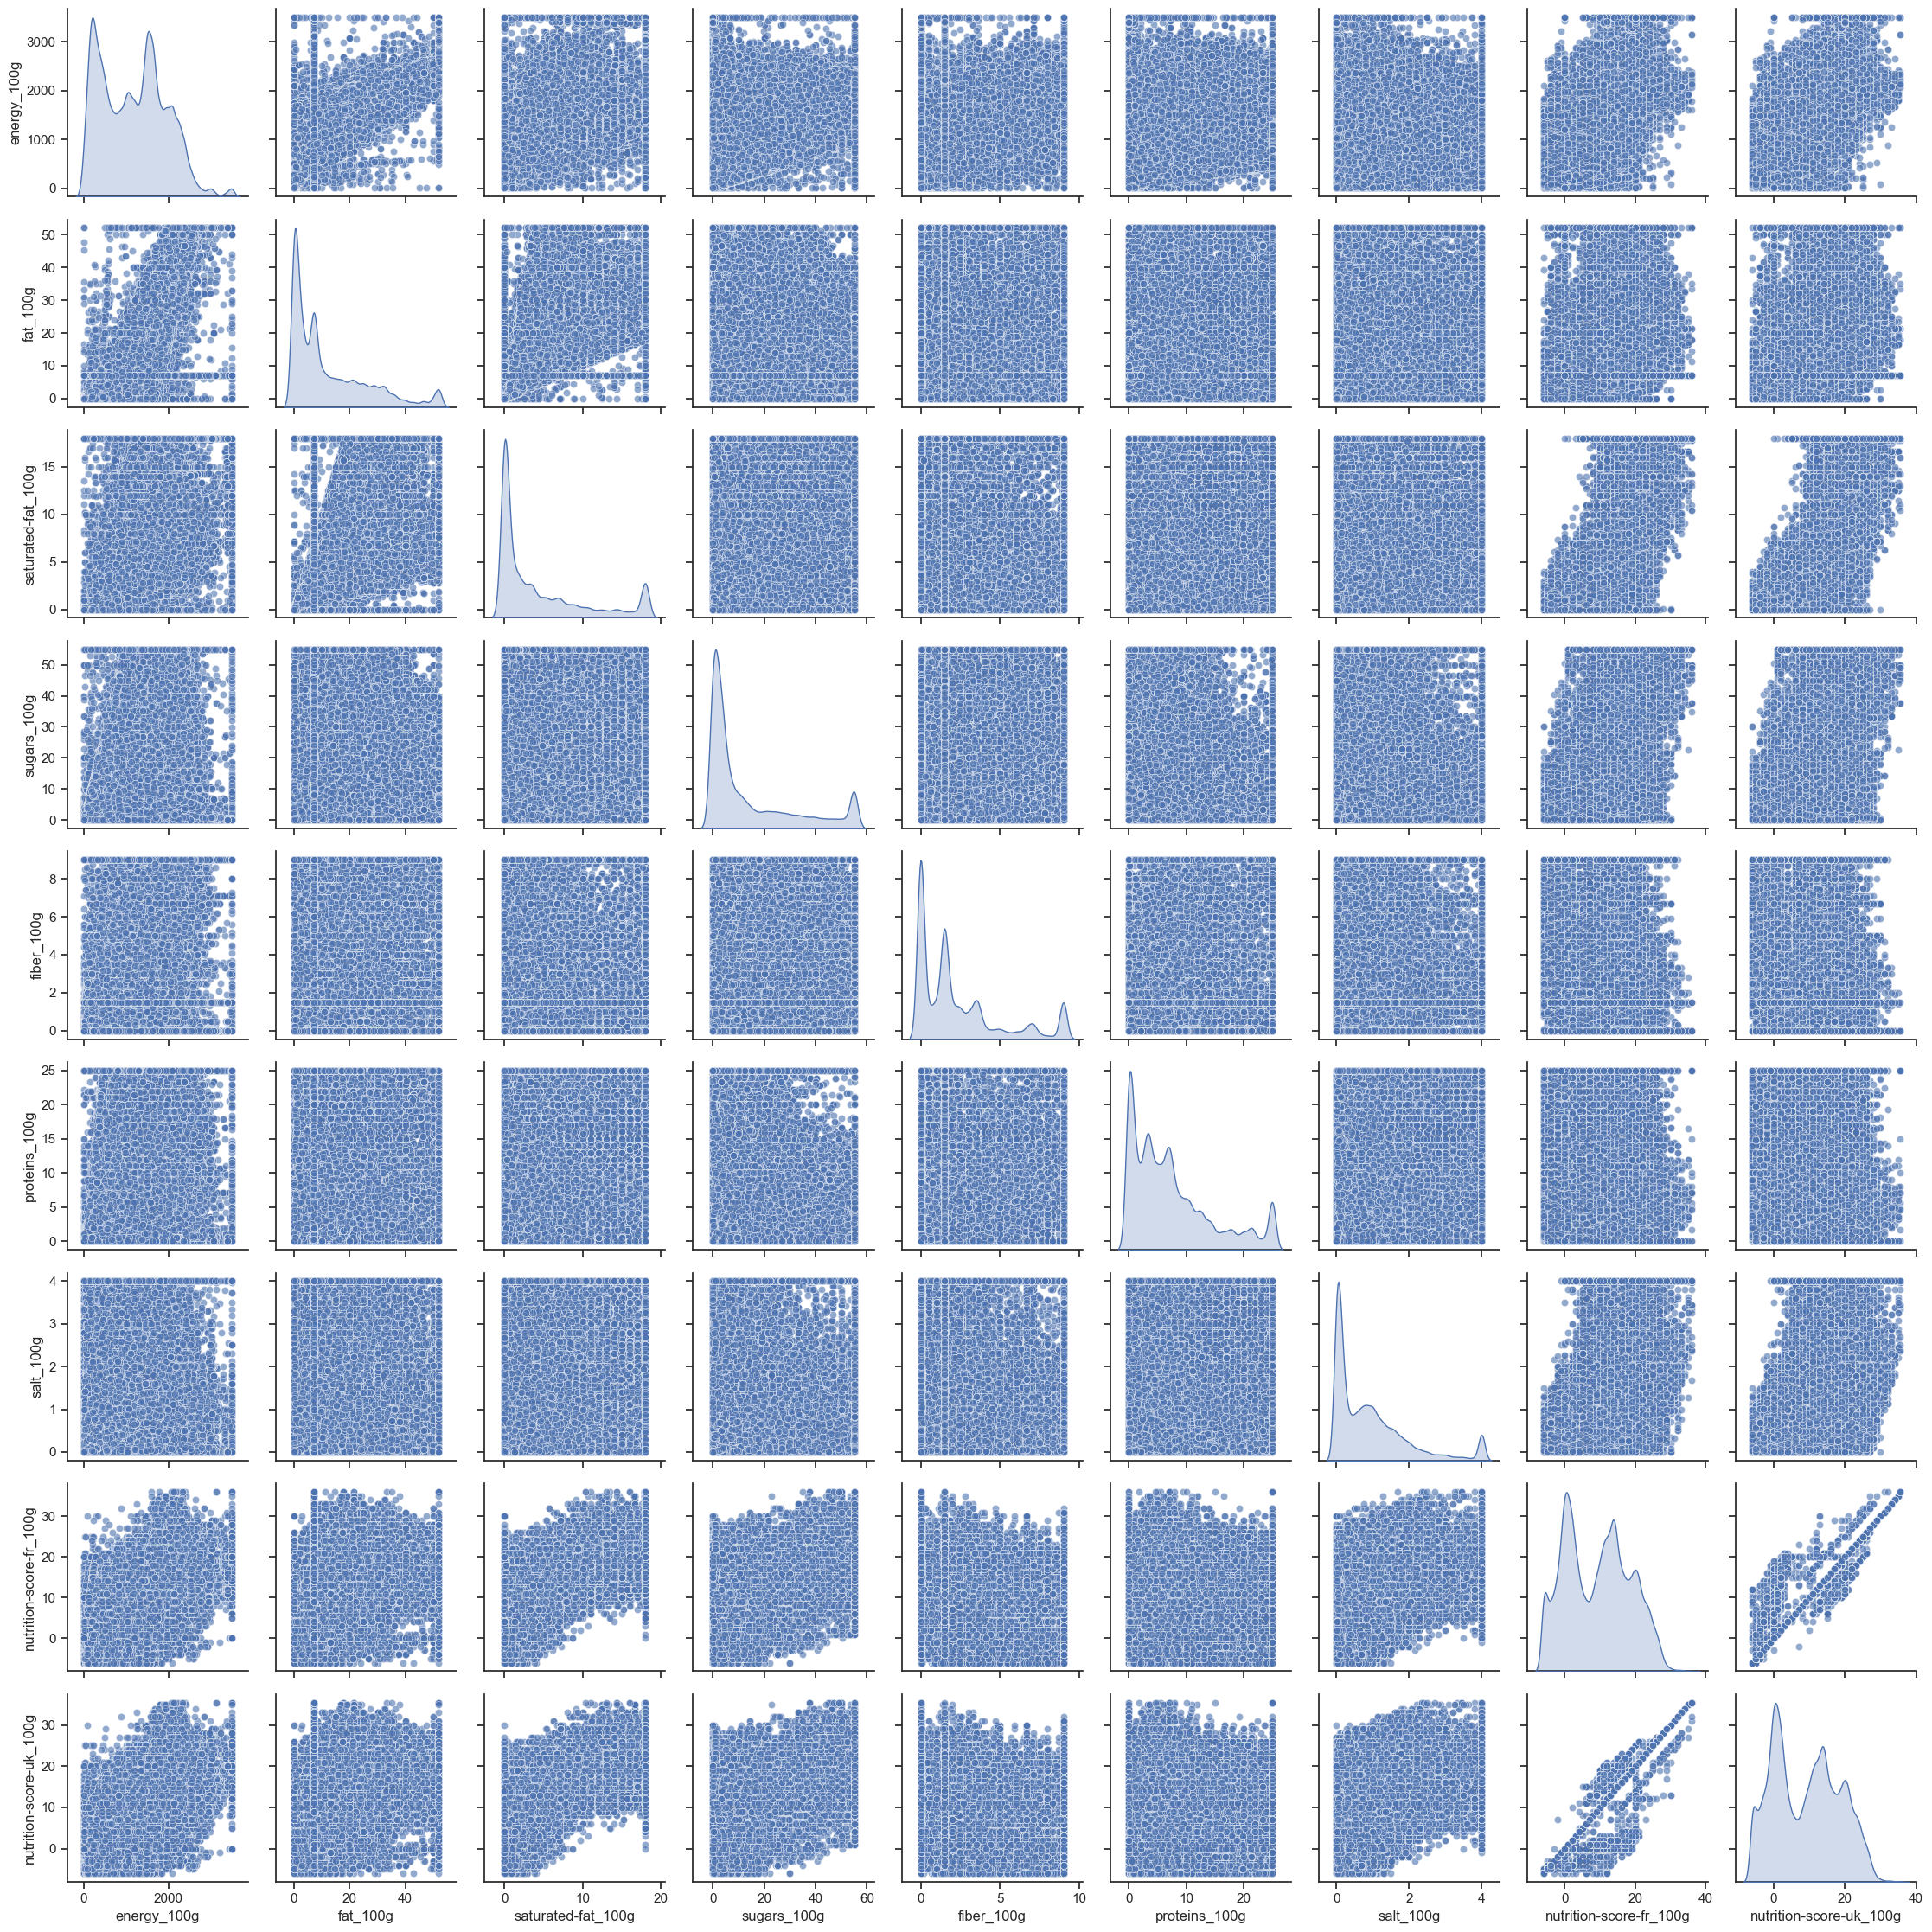

In [48]:
sns.set_theme(style="ticks")
sns.pairplot(XImputed[numericColumns], diag_kind="kde", markers="o", plot_kws={'alpha': 0.6})
plt.tight_layout()
plt.show()


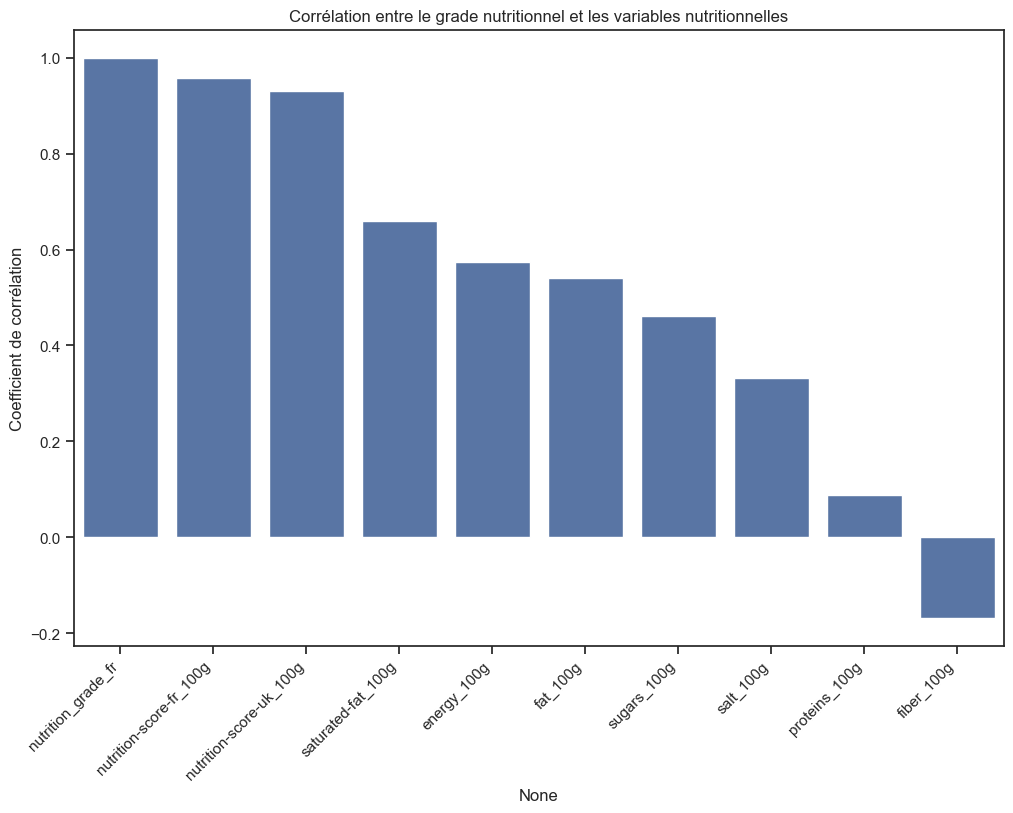

In [49]:
gradeMapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
yNumeric = y.map(gradeMapping)
dataCombined = pd.concat([XImputed, yNumeric], axis=1)
correlations = dataCombined[numericColumns + ['nutrition_grade_fr']].corr()['nutrition_grade_fr'].sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Corrélation entre le grade nutritionnel et les variables nutritionnelles')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Coefficient de corrélation')
plt.show()

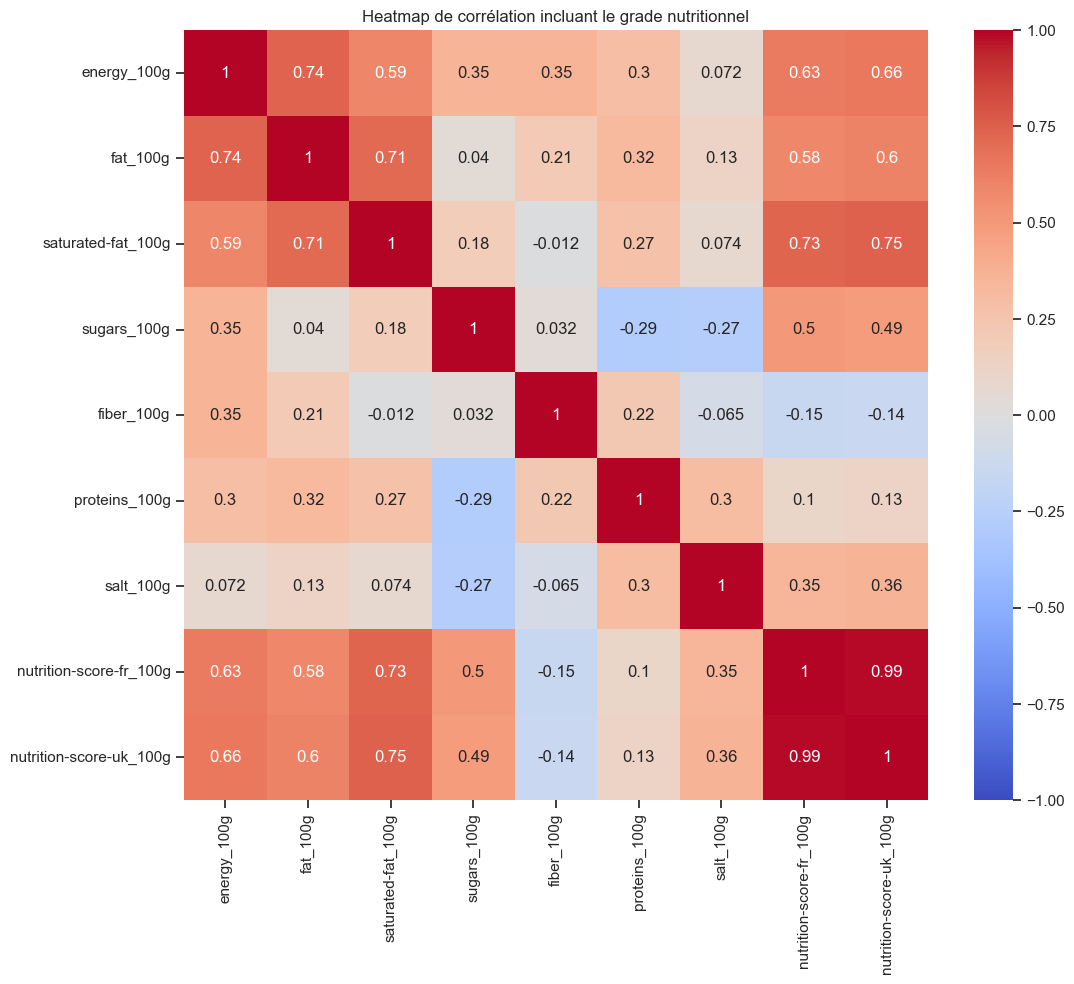

In [50]:
plt.figure(figsize=(12, 10))
sns.heatmap(dataCombined[numericColumns].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Heatmap de corrélation incluant le grade nutritionnel')
plt.show()

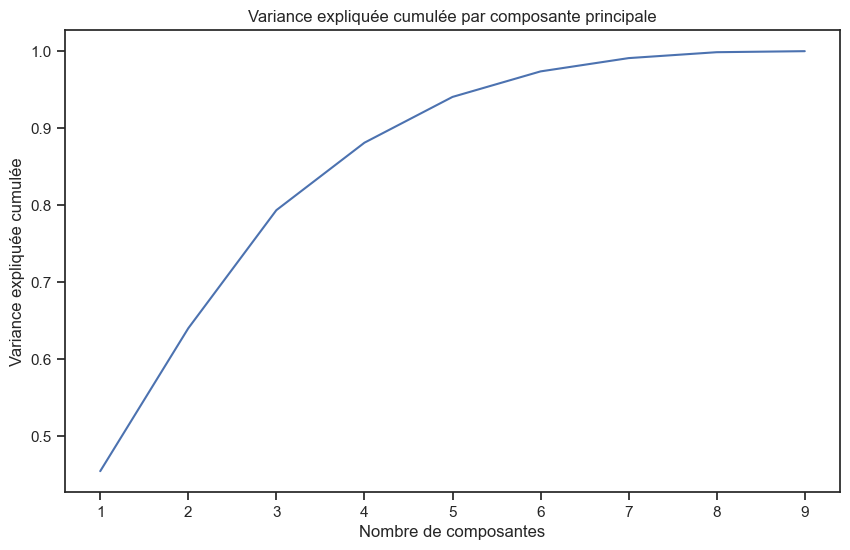

In [51]:
scaler = StandardScaler()
XScaled = scaler.fit_transform(XImputed[numericColumns])

pca = PCA()
XPca = pca.fit_transform(XScaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée par composante principale')
plt.show()

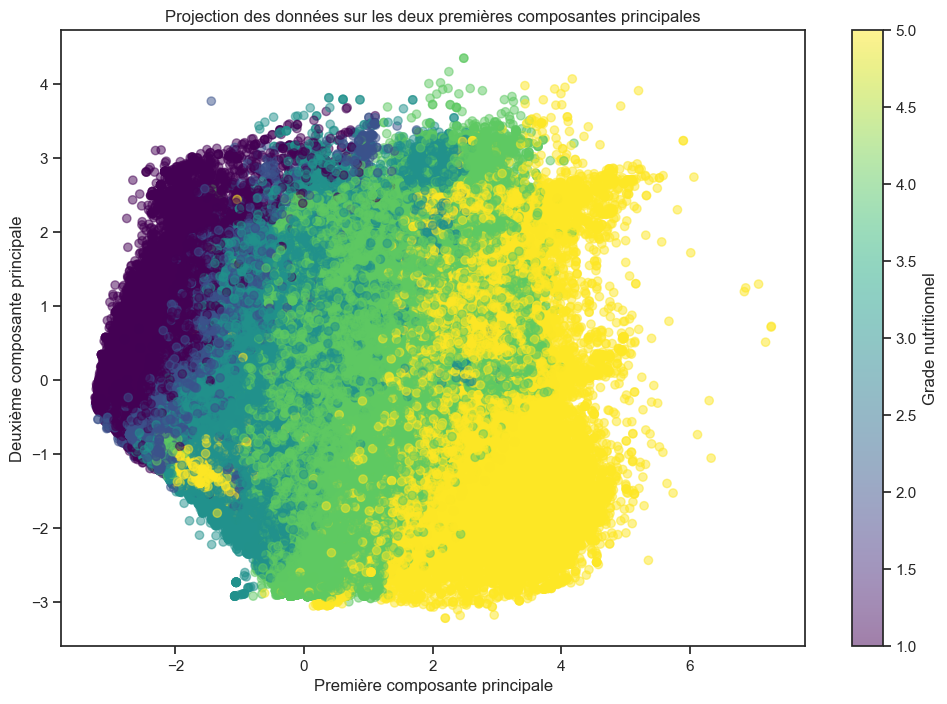

In [52]:
plt.figure(figsize=(12, 8))
plt.scatter(XPca[:, 0], XPca[:, 1], c=yNumeric, cmap='viridis', alpha=0.5)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Projection des données sur les deux premières composantes principales')
plt.colorbar(label='Grade nutritionnel')
plt.show()

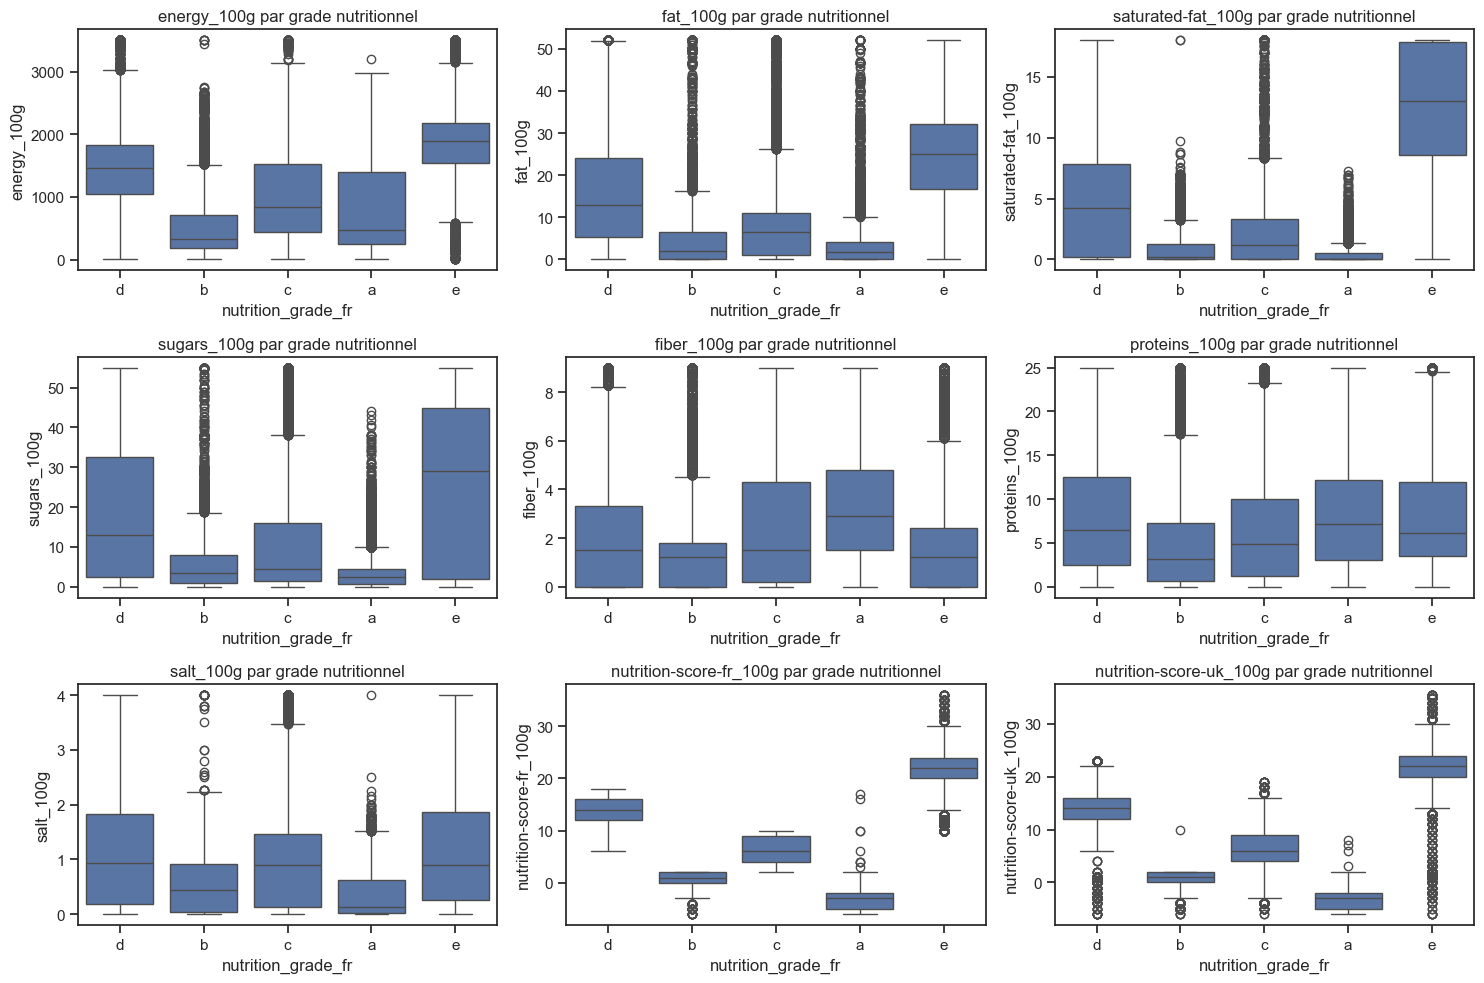

In [53]:
plt.figure(figsize=(15, 10))
for i, var in enumerate(numericColumns, 1):
    if var in XImputed.columns:
        plt.subplot(3, 3, i)
        sns.boxplot(x='nutrition_grade_fr', y=var, data=pd.concat([XImputed, y], axis=1))
        plt.title(f'{var} par grade nutritionnel')
plt.tight_layout()
plt.show()

In [54]:
from scipy import stats

for var in numericColumns:
    if var in XImputed.columns:
        groups = [group for _, group in XImputed[var].groupby(y)]
        f_value, p_value = stats.f_oneway(*groups)
        print(f"ANOVA pour {var}:")
        print(f"F-value: {f_value}")
        print(f"p-value: {p_value}")
        print("---")

ANOVA pour energy_100g:
F-value: 30861.806694097755
p-value: 0.0
---
ANOVA pour fat_100g:
F-value: 23024.39993180413
p-value: 0.0
---
ANOVA pour saturated-fat_100g:
F-value: 59288.135122892374
p-value: 0.0
---
ANOVA pour sugars_100g:
F-value: 14586.345688749005
p-value: 0.0
---
ANOVA pour fiber_100g:
F-value: 3797.2818938103505
p-value: 0.0
---
ANOVA pour proteins_100g:
F-value: 1662.7909915388484
p-value: 0.0
---
ANOVA pour salt_100g:
F-value: 7045.125167204534
p-value: 0.0
---
ANOVA pour nutrition-score-fr_100g:
F-value: 702390.025885954
p-value: 0.0
---
ANOVA pour nutrition-score-uk_100g:
F-value: 375420.0099120054
p-value: 0.0
---
